  0%|          | 0/1 [00:00<?, ?it/s]

999


100%|██████████| 1/1 [00:07<00:00,  7.49s/it]


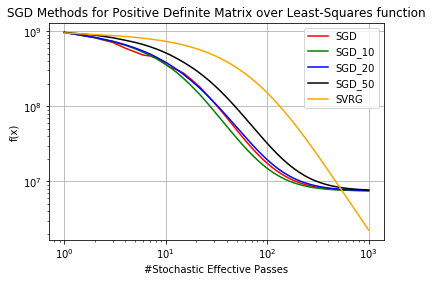

<Figure size 432x288 with 0 Axes>

In [10]:
import numpy as np
import random
from scipy.stats import ortho_group
from tqdm import tqdm
import matplotlib.pyplot as plt

dim = 100
T = 1000
num_of_simulations = 1
passes_SVRG = []

def get_matrix_fix_singular_values(singular_values):
    U = ortho_group.rvs(dim=dim)
    V = ortho_group.rvs(dim=dim)
    S = np.diag(singular_values)
    A = U @ S @ V
    return A

def get_set_params(sigma_max,sigma_min):
    ##from lec2 slide 21
    alpha = sigma_min**2
    beta = sigma_max**2
    return alpha,beta

def gradient_f(A,x,b):
    return np.transpose(A)@(A@x-b)

def f(A,x,b):
    return 0.5*np.linalg.norm(A@x-b)**2

def run_SGD(T,x_1,A,b,alpha,N):
    scores = np.zeros(T)
    x_t_list = [x_1]
    for s in range(1,T):
        if s == 1:
            x_t = x_1
            score = f(A, x_t, b)
            scores[0] = score
        max_iter = int(dim / N)
        for t in range(max_iter):
            rand_idx = np.random.randint(0, dim - 1, N)
            b_tilda = b[rand_idx]
            A_tilda = A[rand_idx, :]
            step = 2 / (alpha * (t + 1))
            x_t = x_t - step * gradient_f(A_tilda,x_t, b_tilda)/N
        x_t_list.append(x_t)
        avg_x = sum(x_t_list)/len(x_t_list)
        score = f(A, avg_x, b)
        scores[s] = score
    return scores

def run_SVRG(T, A, b, beta, k):
    passes_SVRG = []
    epochs = T - int(2*k/dim)  #num of epochs to get to T effective passes
    scores = np.zeros(epochs)
    print(epochs)
    for s in range(1,epochs):
        if s == 1:
            y_s = np.random.uniform(size = dim)
            x_s_list = [y_s]
            score = f(A, y_s, b)
            passes_SVRG.append(1)
            scores[0] = score
        else:
            y_s = sum(x_t_list)/len(x_t_list)
        x_t = y_s
        step = 1 / (10*beta)
        gradient = gradient_f(A,y_s, b)/dim
        x_t_list = [x_t]
        for t in range(k):
            rand_idx = np.random.randint(0, dim - 1, 1)
            b_tilda = b[rand_idx]
            A_tilda = A[rand_idx, :]
            x_t = x_t - step * (gradient_f(A_tilda,x_t, b_tilda) - gradient_f(A_tilda,y_s, b_tilda) + gradient)
            x_t_list.append(x_t)
        passes_SVRG.append(s +int(2*k/dim))
        x_s_list.append(x_t)
        avg_x = sum(x_s_list)/len(x_s_list)
        score = f(A, avg_x, b)
        scores[s] = score
    return scores,passes_SVRG

def get_gradient_scores(sigma_min,sigma_max):
    scores_SGD,scores_SGD_10,scores_SGD_20,scores_SGD_50 = np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T)
    scores_SVRG = np.zeros(T)
    for i in tqdm(range(num_of_simulations),total=num_of_simulations):
        singular_values = [random.uniform(sigma_min, sigma_max) for i in range(dim)]
        singular_values.sort(reverse = True)
        singular_values[-1], singular_values[0] = sigma_min, sigma_max  # fixed sigma_min and sigma_max
        A = get_matrix_fix_singular_values(singular_values)
        x_star = [random.uniform(0,100) for i in range(dim)]
        noise = np.random.normal(size=dim)
        b = np.matmul(A,x_star)+ noise
        alpha,beta = get_set_params(sigma_max,sigma_min)
        x_1 = np.zeros(dim)
        scores_SGD += run_SGD(T,x_1,A,b,alpha,1)
        scores_SGD_10 += run_SGD(T,x_1,A,b,alpha,10)
        scores_SGD_20 += run_SGD(T, x_1, A, b, alpha, 20)
        scores_SGD_50 += run_SGD(T, x_1, A, b, alpha, 50)
        k = int(20 * beta / alpha)
        scores_SVRG_new, passes_SVRG = run_SVRG(T, A, b, beta, k)
        scores_SVRG[:len(scores_SVRG_new)] += scores_SVRG_new
    return scores_SGD,scores_SGD_10,scores_SGD_20,scores_SGD_50,scores_SVRG[:(T - int(2*k/dim))],passes_SVRG

def show_plot(scores_SGD,scores_SGD_10,scores_SGD_20,scores_SGD_50,scores_SVRG,passes_SVRG):
    plt.plot(range(1,T+1), scores_SGD/num_of_simulations,'red')
    plt.plot(range(1,T+1), scores_SGD_10/num_of_simulations,'green')
    plt.plot(range(1,T+1), scores_SGD_20/num_of_simulations,'blue')
    plt.plot(range(1,T+1), scores_SGD_50 / num_of_simulations, 'black')
    plt.plot(passes_SVRG, scores_SVRG / num_of_simulations, 'orange')
    plt.legend(['SGD','SGD_10','SGD_20','SGD_50','SVRG'], loc='best')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.ylabel('f(x)')
    plt.xlabel('#Stochastic Effective Passes')
    plt.title('SGD Methods for Positive Definite Matrix over Least-Squares function')
    plt.savefig('SGD_Methods.png')
    plt.show()
    plt.clf()

if __name__ == "__main__":
    sigma_min, sigma_max = 50, 100
    scores_SGD,scores_SGD_10,scores_SGD_20,scores_SGD_50,scores_SVRG,passes_SVRG = get_gradient_scores(
                                                                                    sigma_min,sigma_max)
    show_plot(scores_SGD,scores_SGD_10,scores_SGD_20,scores_SGD_50,scores_SVRG,passes_SVRG)


In [9]:
epochs

NameError: name 'epochs' is not defined

In [8]:
len(passes_SVRG)

9999